<a href="https://colab.research.google.com/github/bahargermany134-dotcom/-Segmentation---Medical-Chest-X-Ray-Segmentation-/blob/main/LungSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

مدل بارگذاری شد!
تعداد تصاویر تست: 96


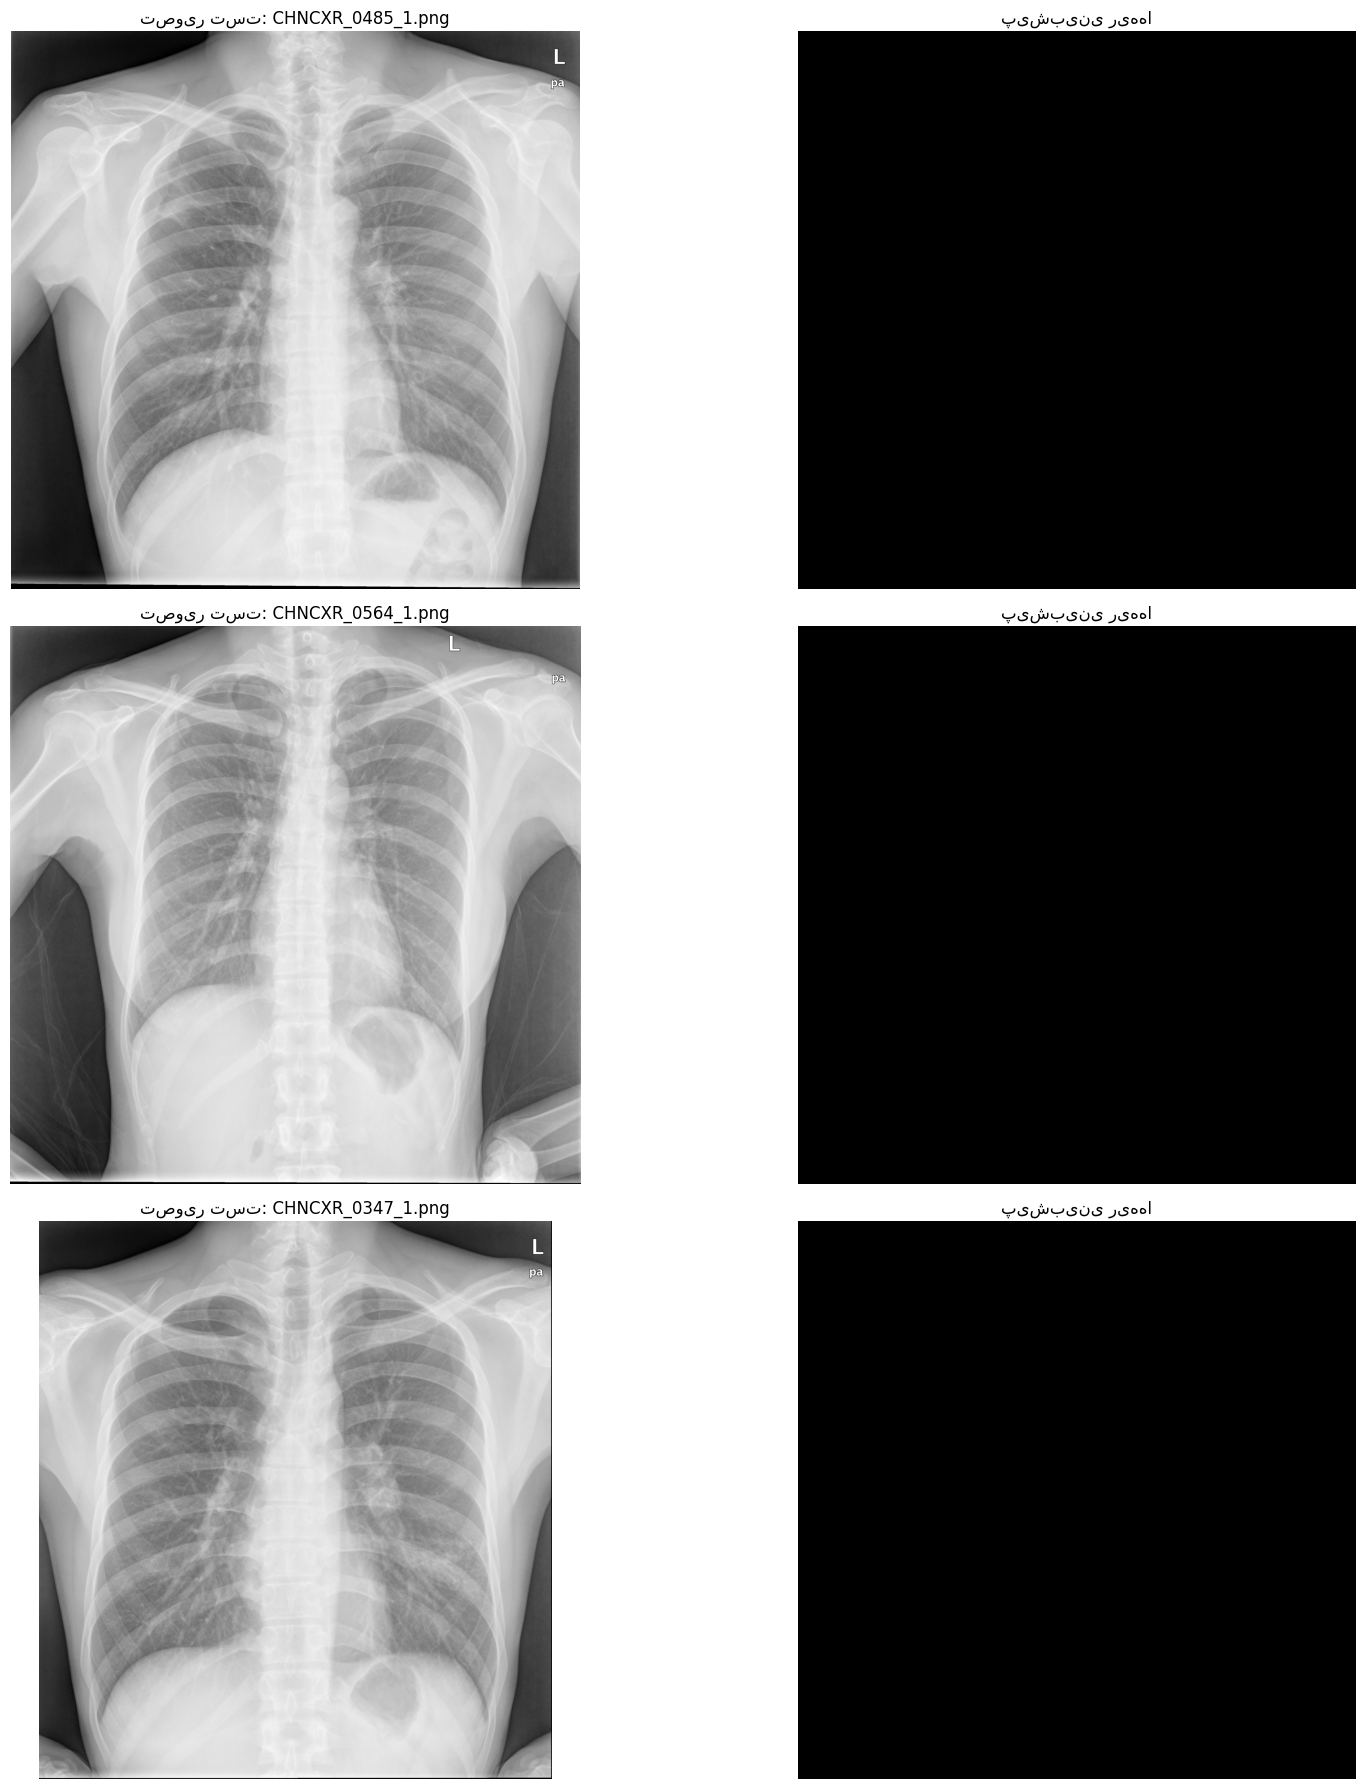

تست با موفقیت انجام شد!


In [ ]:
# ================= تست مدل روی پوشه test — با Resize =================

import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import albumentations as A

# --- مسیرها ---
model_path = '/content/lung_unet_model.pth'
test_dir = '/content/lung_dataset/Lung Segmentation/test'

# --- بارگذاری مدل ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# تعریف دوباره U-Net (همون کلاس قبلی)
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = double_conv(3, 64); self.pool = nn.MaxPool2d(2)
        self.enc2 = double_conv(64, 128)
        self.enc3 = double_conv(128, 256)
        self.enc4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2); self.dec4 = double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2);  self.dec3 = double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2);  self.dec2 = double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2);   self.dec1 = double_conv(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.up4(b);  d4 = torch.cat([d4, e4], 1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, e3], 1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], 1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], 1); d1 = self.dec1(d1)
        return torch.sigmoid(self.final(d1))

model = UNet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

print("مدل بارگذاری شد!")

# --- تحولات فقط برای تست ---
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# --- تابع پیش‌بینی ---
def predict_mask(image_path):
    # خواندن تصویر
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)  # برای نمایش

    # اعمال تحولات
    transformed = test_transform(image=img_np)
    img_tensor = transformed['image']
    img_tensor = torch.from_numpy(img_tensor).permute(2, 0, 1).float()
    img_tensor = img_tensor.unsqueeze(0).to(device)  # (1, 3, 256, 256)

    with torch.no_grad():
        pred = model(img_tensor)
        pred = (pred > 0.5).float()
        pred = pred.squeeze(0).squeeze(0).cpu().numpy()  # (256, 256)

    return img_np, pred

# --- نمایش چند تصویر تست ---
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg'))]
print(f"تعداد تصاویر تست: {len(test_images)}")

import random
selected = random.sample(test_images, min(3, len(test_images)))

plt.figure(figsize=(18, 6 * len(selected)))
for idx, img_name in enumerate(selected):
    img_path = os.path.join(test_dir, img_name)
    orig_img, pred_mask = predict_mask(img_path)

    plt.subplot(len(selected), 2, 2*idx + 1)
    plt.title(f"تصویر تست: {img_name}", fontsize=12)
    plt.imshow(orig_img)
    plt.axis('off')

    plt.subplot(len(selected), 2, 2*idx + 2)
    plt.title("پیش‌بینی ریه‌ها", fontsize=12)
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("تست با موفقیت انجام شد!")

In [ ]:
# ================= مرحله ۱: استخراج و بررسی دیتاست =================

from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os
import shutil

#
zip_path = '/content/drive/MyDrive/lung_segmentation.zip'
extract_path = '/content/lung_dataset'

print("در حال بررسی فایل ZIP...")

# --- چک کردن وجود فایل ---
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"""
    فایل پیدا نشد!
    مسیر: {zip_path}

    فایل‌های موجود در MyDrive:
    """)
    !ls -lh "/content/drive/MyDrive/" | grep -i lung

# --- چک کردن حجم ---
size_mb = os.path.getsize(zip_path) / (1024*1024)
print(f"حجم فایل: {size_mb:.2f} MB")

if size_mb < 1:
    print("هشدار: حجم خیلی کم است! فایل احتمالاً خراب یا خالی است.")
else:
    print("حجم مناسب است.")

# --- تست ZIP و استخراج ---
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f"فایل ZIP معتبر است! تعداد فایل‌ها: {len(zip_ref.namelist())}")

        # نمایش ۱۰ فایل اول
        print("\n۱۰ فایل اول در زیپ:")
        for i, name in enumerate(zip_ref.namelist()[:10]):
            print(f"  {i+1}. {name}")
        if len(zip_ref.namelist()) > 10:
            print("  ...")

        # پاک کردن پوشه قبلی
        if os.path.exists(extract_path):
            print(f"پاک کردن پوشه قبلی: {extract_path}")
            shutil.rmtree(extract_path)

        os.makedirs(extract_path, exist_ok=True)

        print(f"\nاستخراج به: {extract_path}")
        zip_ref.extractall(extract_path)
        print("استخراج با موفقیت انجام شد!")

        # --- نمایش ساختار ---
        print("\nساختار پوشه‌ها:")
        !find "{extract_path}" -type d | head -15

        # --- پیدا کردن پوشه‌های تصاویر و ماسک ---
        all_items = os.listdir(extract_path)
        img_dirs = [d for d in all_items if any(x in d.lower() for x in ['image', 'img', 'data', 'input'])]
        mask_dirs = [d for d in all_items if any(x in d.lower() for x in ['mask', 'label', 'seg', 'ground', 'annotation'])]

        print(f"\nپوشه‌های احتمالی تصاویر: {img_dirs}")
        print(f"پوشه‌های احتمالی ماسک: {mask_dirs}")

        if img_dirs and mask_dirs:
            img_dir = os.path.join(extract_path, img_dirs[0])
            mask_dir = os.path.join(extract_path, mask_dirs[0])
            print(f"\nتصاویر در: {img_dir}")
            print(f"ماسک‌ها در: {mask_dir}")
            !echo "۵ تصویر اول:"
            !ls "{img_dir}" | head -5
            !echo "۵ ماسک اول:"
            !ls "{mask_dir}" | head -5
        else:
            print("\nپوشه‌های استاندارد پیدا نشد. ساختار کامل:")
            !ls -R "{extract_path}" | head -30

except zipfile.BadZipFile:
    print("خطا: فایل ZIP خراب یا معتبر نیست!")
    print("راه‌حل:")

except Exception as e:
    print(f"خطای دیگر: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
در حال بررسی فایل ZIP...
حجم فایل: 797.16 MB
حجم مناسب است.
فایل ZIP معتبر است! تعداد فایل‌ها: 2408

۱۰ فایل اول در زیپ:
  1. Lung Segmentation/
  2. Lung Segmentation/NLM-ChinaCXRSet-ReadMe.docx
  3. Lung Segmentation/.DS_Store
  4. Lung Segmentation/test/
  5. Lung Segmentation/test/CHNCXR_0492_1.png
  6. Lung Segmentation/test/CHNCXR_0187_0.png
  7. Lung Segmentation/test/CHNCXR_0342_1.png
  8. Lung Segmentation/test/CHNCXR_0203_0.png
  9. Lung Segmentation/test/CHNCXR_0218_0.png
  10. Lung Segmentation/test/CHNCXR_0039_0.png
  ...

استخراج به: /content/lung_dataset
استخراج با موفقیت انجام شد!

ساختار پوشه‌ها:
/content/lung_dataset
/content/lung_dataset/Lung Segmentation
/content/lung_dataset/Lung Segmentation/ClinicalReadings
/content/lung_dataset/Lung Segmentation/CXR_png_resized
/content/lung_dataset/Lung Segmentation/test
/content/lung_dataset/Lung Seg

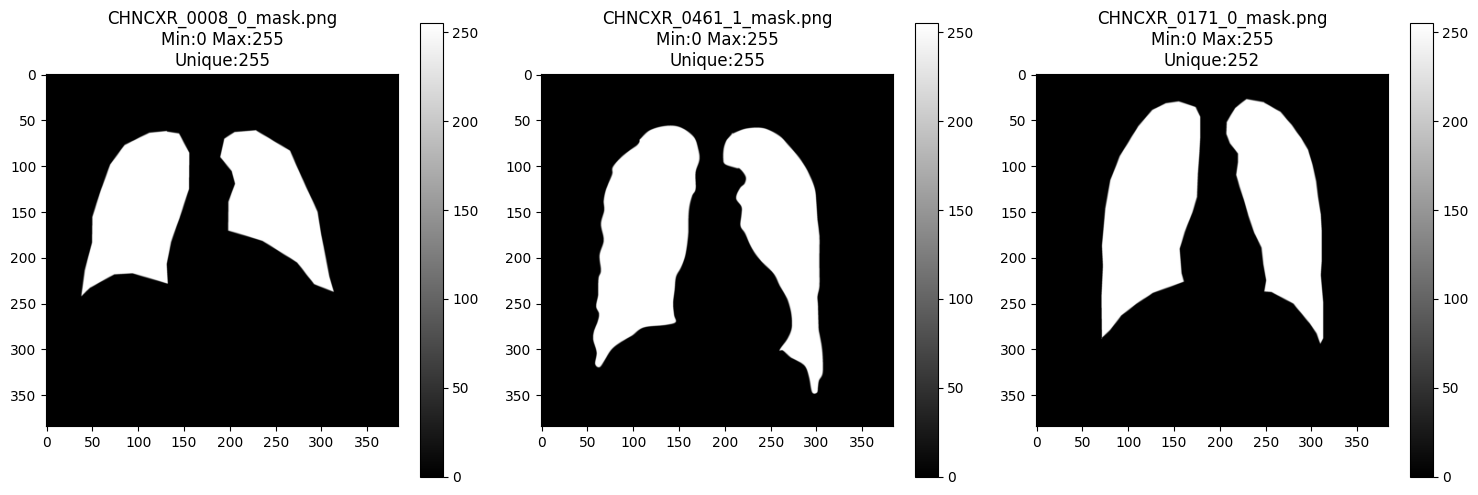

In [ ]:
# چک کردن ۳ ماسک واقعی
mask_dir = '/content/lung_dataset/Lung Segmentation/masks_resized'
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('_mask.png')][:3]

plt.figure(figsize=(15, 5))
for i, mf in enumerate(mask_files):
    mask_path = os.path.join(mask_dir, mf)
    mask = Image.open(mask_path).convert("L")
    mask_np = np.array(mask)

    plt.subplot(1, 3, i+1)
    plt.title(f"{mf}\nMin:{mask_np.min()} Max:{mask_np.max()}\nUnique:{len(np.unique(mask_np))}")
    plt.imshow(mask_np, cmap='gray')
    plt.colorbar()
plt.tight_layout()
plt.show()

تعداد تصاویر با ماسک: 566

تست یک بچ...
Image: torch.Size([4, 3, 256, 256]), Mask: torch.Size([4, 1, 256, 256])

شروع آموزش روی 566 تصویر...
  Epoch 1 | Batch 0 | Loss: 0.6515
Epoch [1/20] - Avg Loss: 0.2090

  Epoch 2 | Batch 0 | Loss: 0.1261
Epoch [2/20] - Avg Loss: 0.1282

  Epoch 3 | Batch 0 | Loss: 0.1792
Epoch [3/20] - Avg Loss: 0.1110

  Epoch 4 | Batch 0 | Loss: 0.0759
Epoch [4/20] - Avg Loss: 0.0929

  Epoch 5 | Batch 0 | Loss: 0.0561
Epoch [5/20] - Avg Loss: 0.0874

  Epoch 6 | Batch 0 | Loss: 0.0688
Epoch [6/20] - Avg Loss: 0.0769

  Epoch 7 | Batch 0 | Loss: 0.0585
Epoch [7/20] - Avg Loss: 0.0729

  Epoch 8 | Batch 0 | Loss: 0.0593
Epoch [8/20] - Avg Loss: 0.0697

  Epoch 9 | Batch 0 | Loss: 0.0645
Epoch [9/20] - Avg Loss: 0.0664

  Epoch 10 | Batch 0 | Loss: 0.0577
Epoch [10/20] - Avg Loss: 0.0702

  Epoch 11 | Batch 0 | Loss: 0.0911
Epoch [11/20] - Avg Loss: 0.0685

  Epoch 12 | Batch 0 | Loss: 0.0901
Epoch [12/20] - Avg Loss: 0.0634

  Epoch 13 | Batch 0 | Loss: 0.0772
E

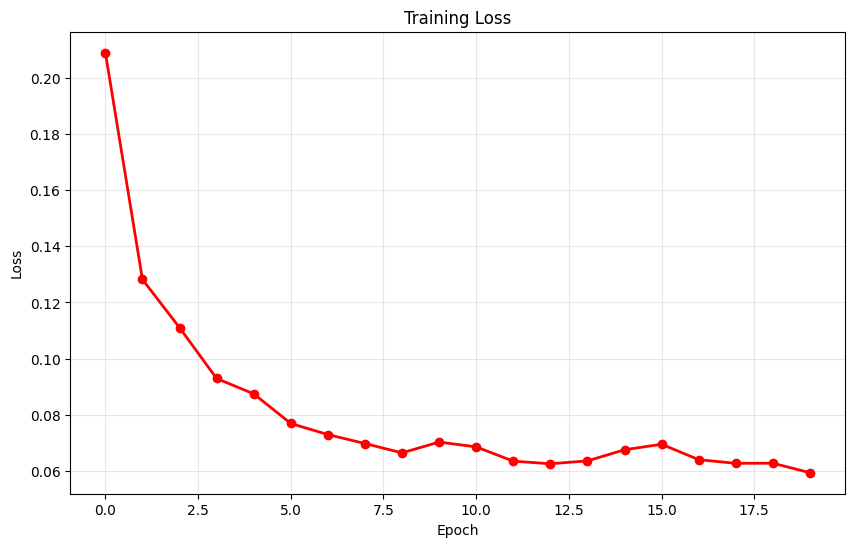

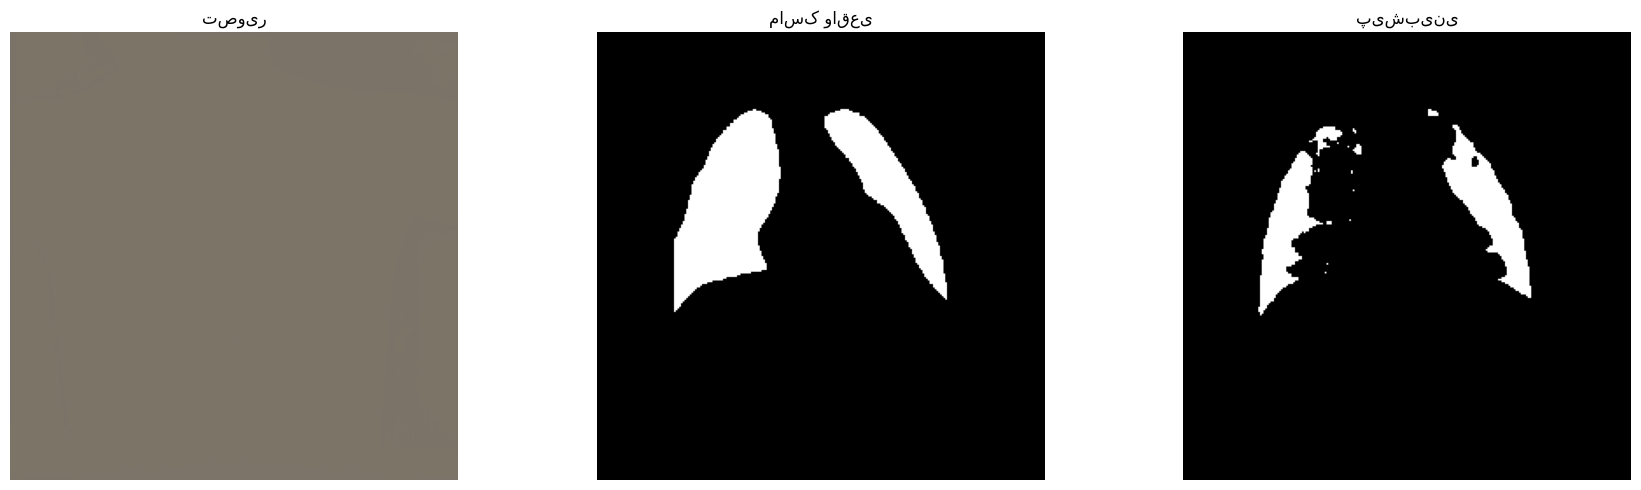

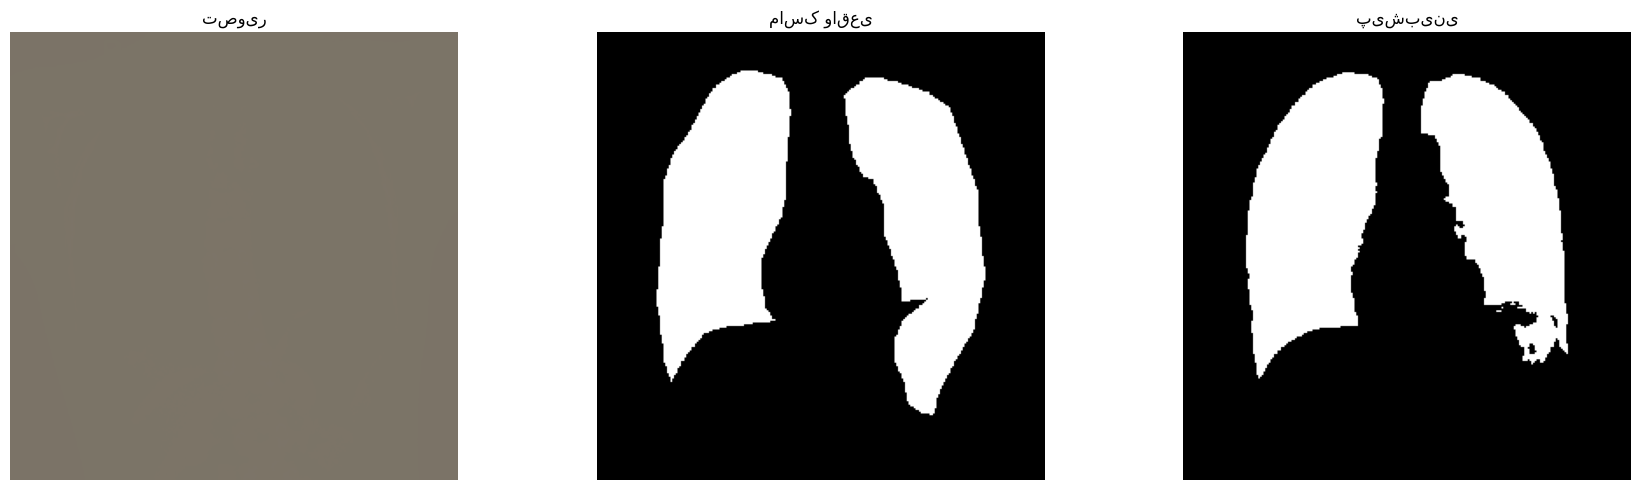

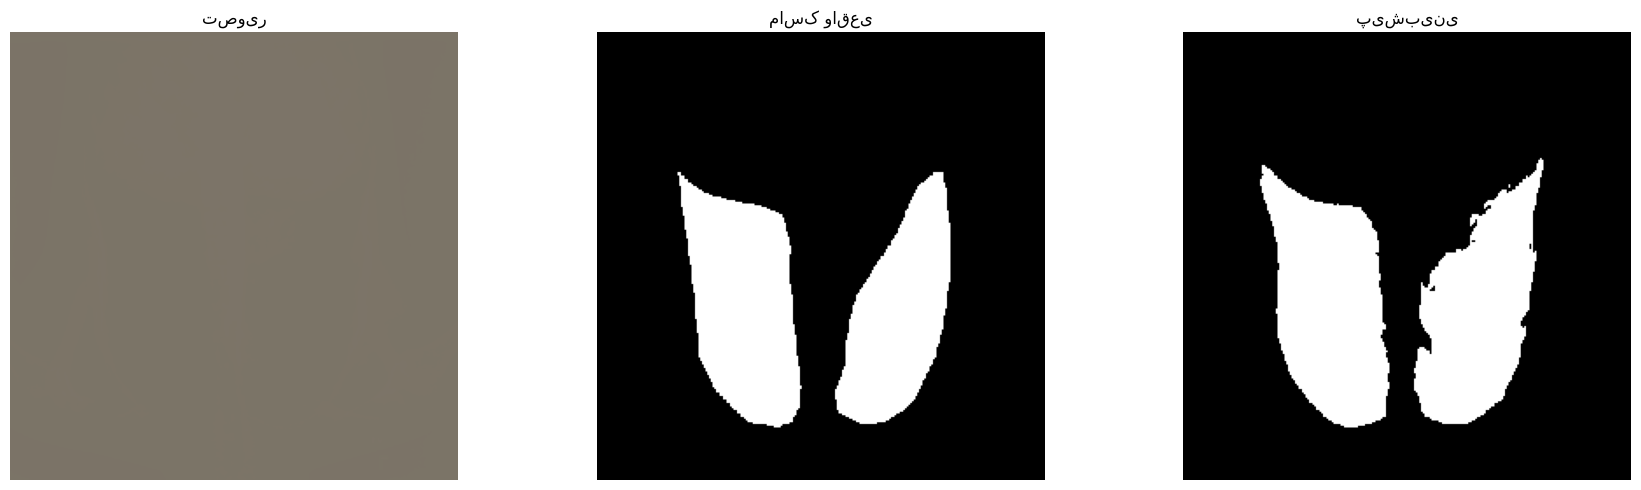

مدل نهایی ذخیره شد: /content/lung_unet_model_final.pth


In [ ]:
#

!pip install torch torchvision albumentations matplotlib -q

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import os

# --- مسیرها ---
base_path = '/content/lung_dataset/Lung Segmentation'
image_dir = os.path.join(base_path, 'CXR_png_resized')
mask_dir = os.path.join(base_path, 'masks_resized')

# --- دیتاست ---
class LungDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        all_images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg'))]

        self.mask_map = {}
        for mask_file in os.listdir(mask_dir):
            if mask_file.lower().endswith(('.png', '.jpg')):
                base = mask_file.replace('_mask.png', '').replace('_mask.jpg', '')
                self.mask_map[base] = mask_file

        self.valid_images = [img for img in all_images if os.path.splitext(img)[0] in self.mask_map]
        self.valid_images = sorted(self.valid_images)

        print(f"تعداد تصاویر با ماسک: {len(self.valid_images)}")

    def __len__(self): return len(self.valid_images)

    def __getitem__(self, idx):
        img_name = self.valid_images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_file = self.mask_map[base_name]
        mask_path = os.path.join(self.mask_dir, mask_file)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']

        image = torch.from_numpy(image).permute(2,0,1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        return image, mask

# --- تحولات ---
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
], is_check_shapes=False)

dataset = LungDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# --- تست دیتاست ---
print("\nتست یک بچ...")
for img, mask in dataloader:
    print(f"Image: {img.shape}, Mask: {mask.shape}")
    break

# --- مدل ---
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = double_conv(3, 64); self.pool = nn.MaxPool2d(2)
        self.enc2 = double_conv(64, 128)
        self.enc3 = double_conv(128, 256)
        self.enc4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2); self.dec4 = double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2);  self.dec3 = double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2);  self.dec2 = double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2);   self.dec1 = double_conv(128, 64)
        self.final = nn.Conv2d(64, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.up4(b);  d4 = torch.cat([d4, e4], 1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, e3], 1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], 1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], 1); d1 = self.dec1(d1)
        return torch.sigmoid(self.final(d1))

# --- آموزش (فقط یک بار!) ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # lr بالا

print(f"\nشروع آموزش روی {len(dataset)} تصویر...")
losses = []

for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for i, (img, mask) in enumerate(dataloader):
        img, mask = img.to(device), mask.to(device)
        out = model(img)
        loss = criterion(out, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if i == 0:
            print(f"  Epoch {epoch+1} | Batch 0 | Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/20] - Avg Loss: {avg_loss:.4f}\n")

# --- نمودار Loss ---
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', color='red', linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# --- نمایش نتیجه ---
model.eval()
with torch.no_grad():
    img, mask = next(iter(dataloader))
    img, mask = img.to(device), mask.to(device)
    pred = (model(img) > 0.5).float()

    for i in range(3):
        im = img[i].cpu().permute(1,2,0).numpy()
        im = im * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        im = np.clip(im, 0, 1)

        plt.figure(figsize=(18,5))
        plt.subplot(131); plt.title("تصویر"); plt.imshow(im); plt.axis('off')
        plt.subplot(132); plt.title("ماسک واقعی"); plt.imshow(mask[i,0].cpu(), cmap='gray'); plt.axis('off')
        plt.subplot(133); plt.title("پیش‌بینی"); plt.imshow(pred[i,0].cpu(), cmap='gray'); plt.axis('off')
        plt.tight_layout()
        plt.show()

# --- ذخیره ---
torch.save(model.state_dict(), '/content/lung_unet_model_final.pth')
print("مدل نهایی ذخیره شد: /content/lung_unet_model_final.pth")

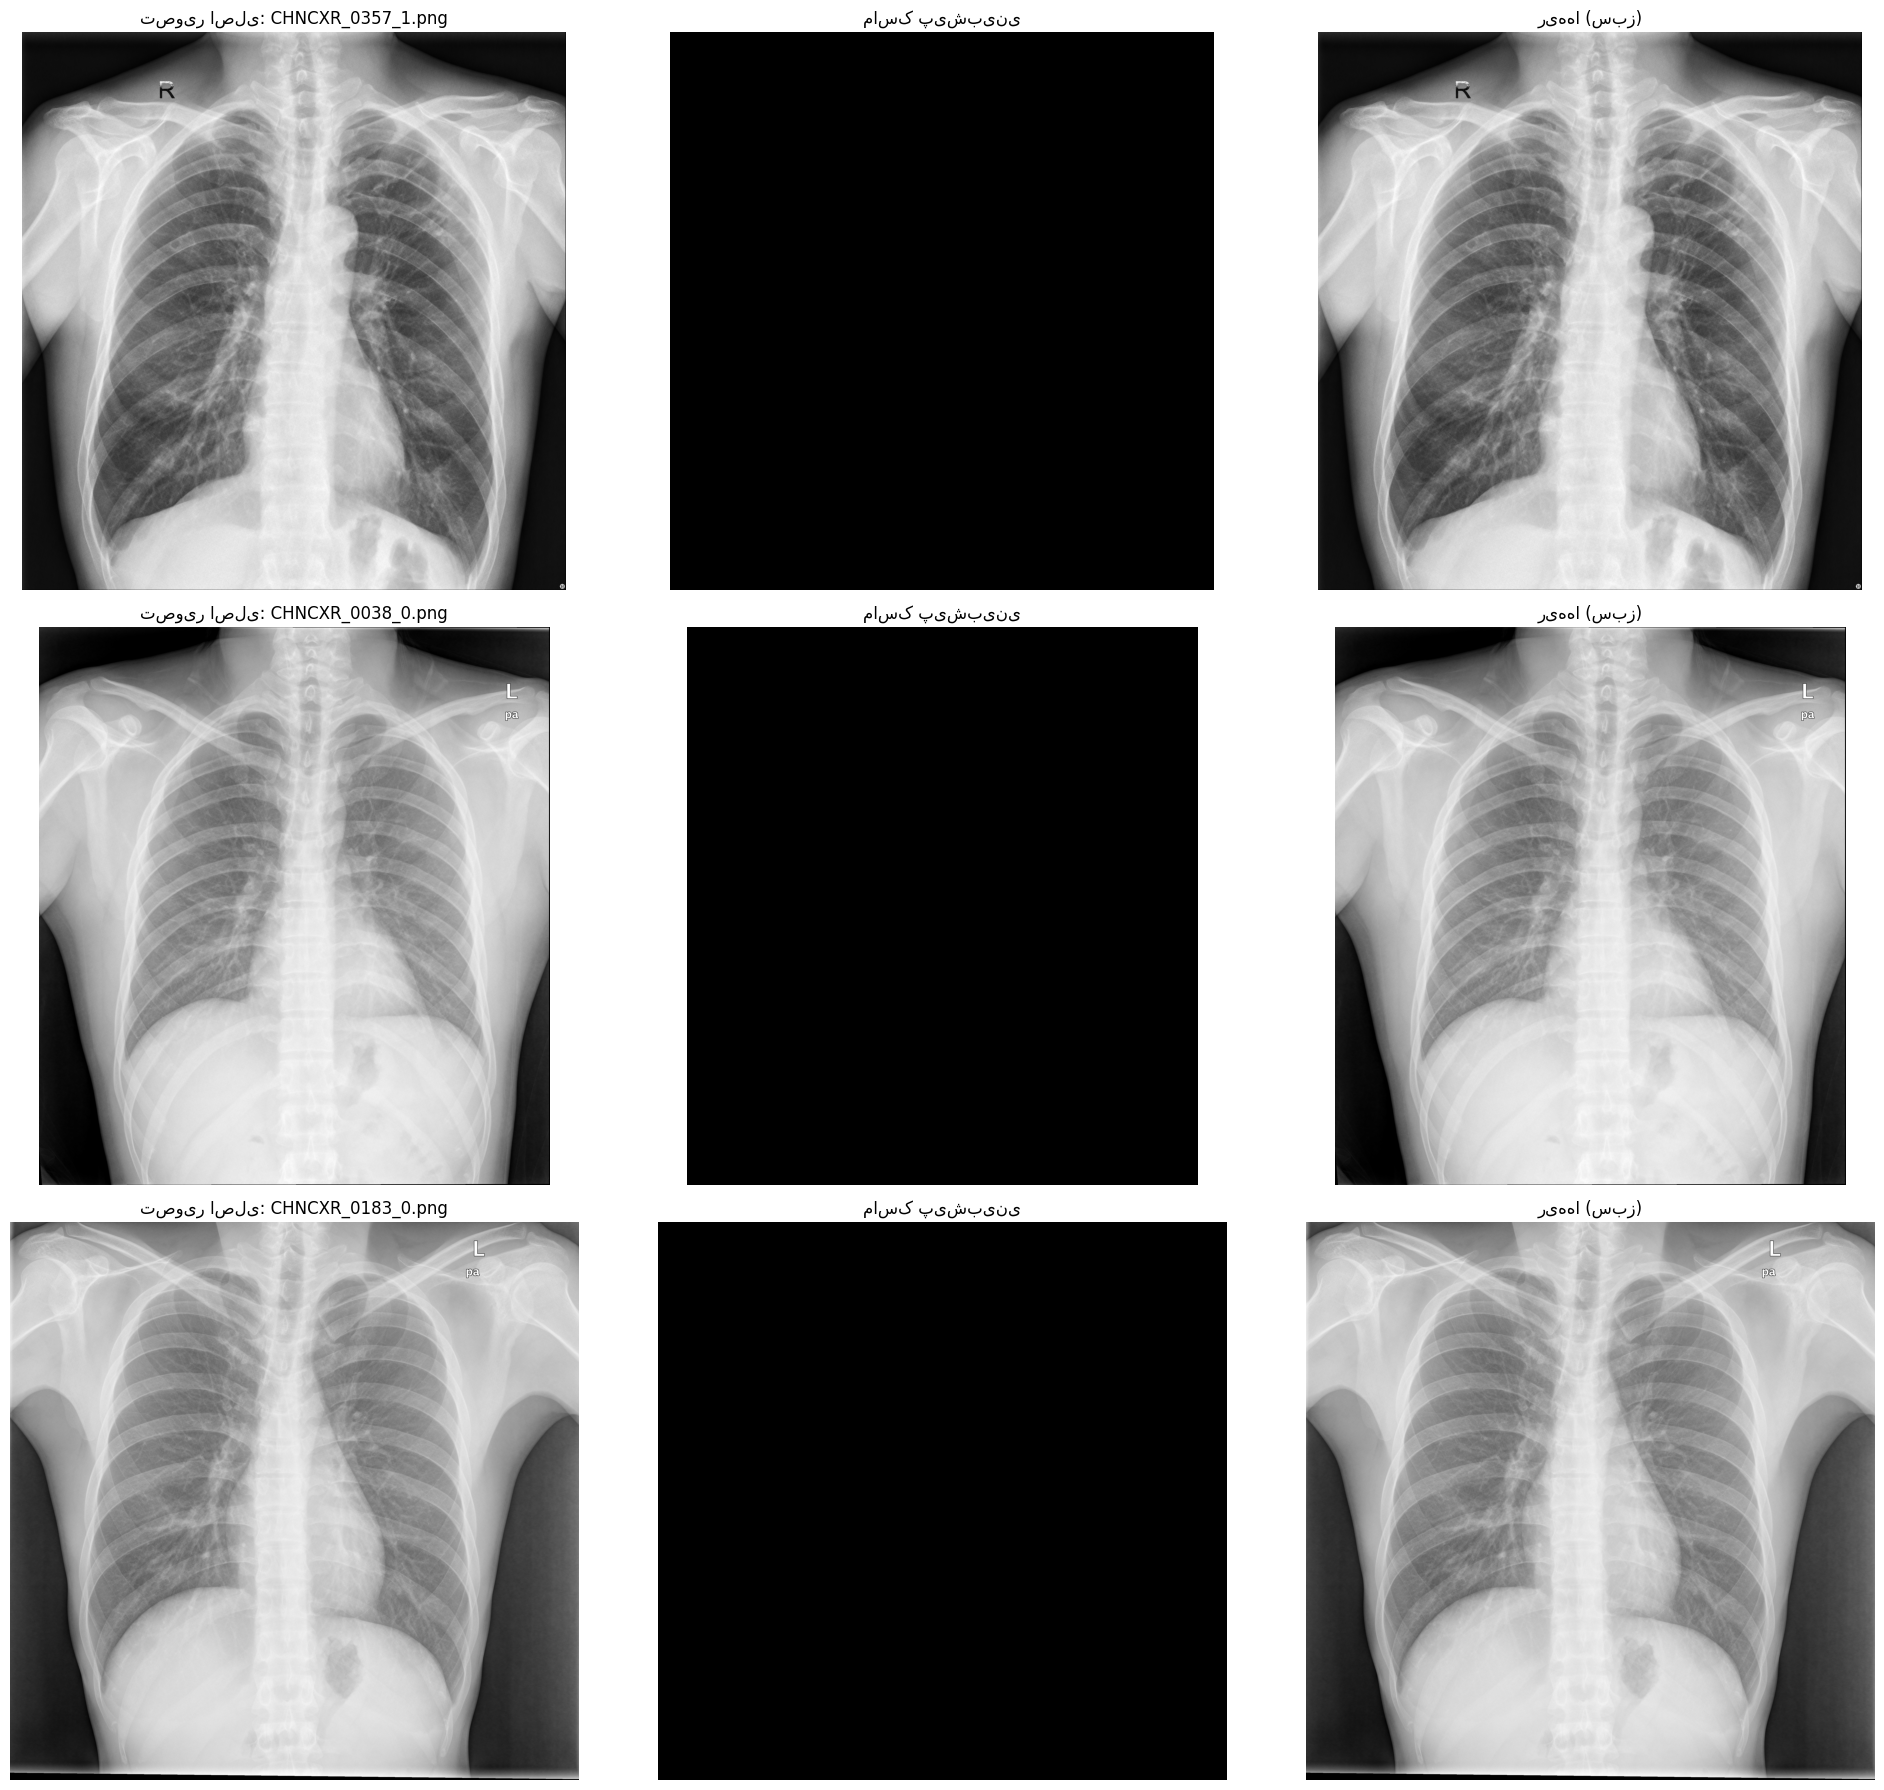

تست کامل شد! ریه‌ها باید سبز باشند!


In [ ]:
# ================= تست نهایی روی test با سبز =================

import cv2
import random

# لیست واقعی فایل‌ها
test_dir = '/content/lung_dataset/Lung Segmentation/test'
test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg'))]
selected = random.sample(test_files, 3)  # 3 تصویر تصادفی

# تحولات تست — دقیقاً مثل آموزش
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

def predict_with_overlay(image_path):
    img = Image.open(image_path).convert("RGB")
    orig_np = np.array(img)  # uint8

    # --- پیش‌پردازش دقیق ---
    transformed = test_transform(image=orig_np)
    tensor = torch.from_numpy(transformed['image']).permute(2, 0, 1).float().unsqueeze(0).to(device)

    # --- پیش‌بینی ---
    with torch.no_grad():
        pred = (model(tensor) > 0.5).float().squeeze(0).squeeze(0).cpu().numpy()  # (256,256)

    # --- resize ماسک به اندازه اصلی ---
    pred_resized = cv2.resize(pred, (orig_np.shape[1], orig_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # --- overlay سبز ---
    overlay = orig_np.copy()
    overlay[pred_resized > 0.5] = [0, 255, 0]  # سبز

    return orig_np, pred_resized, overlay

# --- نمایش ---
plt.figure(figsize=(20, 6*len(selected)))
for i, name in enumerate(selected):
    path = os.path.join(test_dir, name)
    orig, mask, overlay = predict_with_overlay(path)

    plt.subplot(len(selected), 3, 3*i + 1)
    plt.title(f"تصویر اصلی: {name}", fontsize=12)
    plt.imshow(orig); plt.axis('off')

    plt.subplot(len(selected), 3, 3*i + 2)
    plt.title("ماسک پیش‌بینی")
    plt.imshow(mask, cmap='gray'); plt.axis('off')

    plt.subplot(len(selected), 3, 3*i + 3)
    plt.title("ریه‌ها (سبز)")
    plt.imshow(overlay); plt.axis('off')

plt.tight_layout()
plt.show()

print("تست کامل شد! ریه‌ها باید سبز باشند!")

تعداد تصاویر با ماسک: 566

چک یک بچ...
Image: torch.Size([4, 3, 256, 256]), min=-2.118, max=2.640
Mask:  torch.Size([4, 1, 256, 256]), min=0.0, max=1.0

شروع آموزش روی 566 تصویر...
Epoch [1/20] - Loss: 0.2259
Epoch [2/20] - Loss: 0.1317
Epoch [3/20] - Loss: 0.1068
Epoch [4/20] - Loss: 0.0911
Epoch [5/20] - Loss: 0.0851
Epoch [6/20] - Loss: 0.0808
Epoch [7/20] - Loss: 0.0754
Epoch [8/20] - Loss: 0.0749
Epoch [9/20] - Loss: 0.0699
Epoch [10/20] - Loss: 0.0690
Epoch [11/20] - Loss: 0.0679
Epoch [12/20] - Loss: 0.0774
Epoch [13/20] - Loss: 0.0692
Epoch [14/20] - Loss: 0.0661
Epoch [15/20] - Loss: 0.0647
Epoch [16/20] - Loss: 0.0648
Epoch [17/20] - Loss: 0.0620
Epoch [18/20] - Loss: 0.0610
Epoch [19/20] - Loss: 0.0608
Epoch [20/20] - Loss: 0.0608


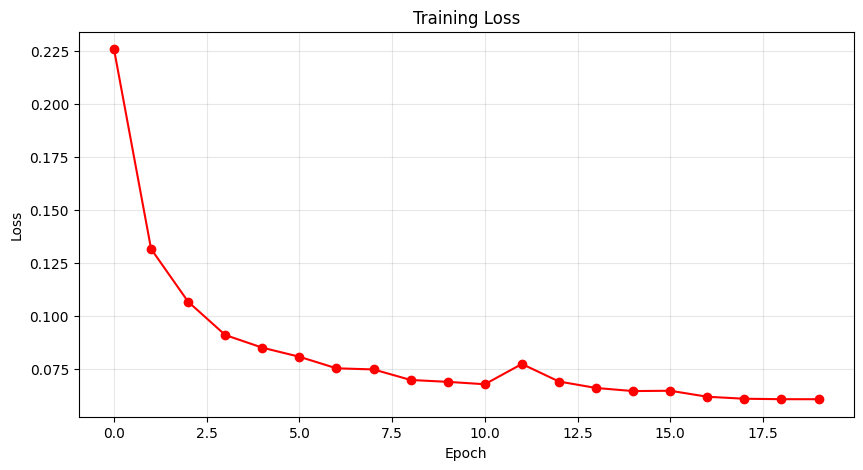

مدل ذخیره شد: /content/lung_unet_model_final.pth


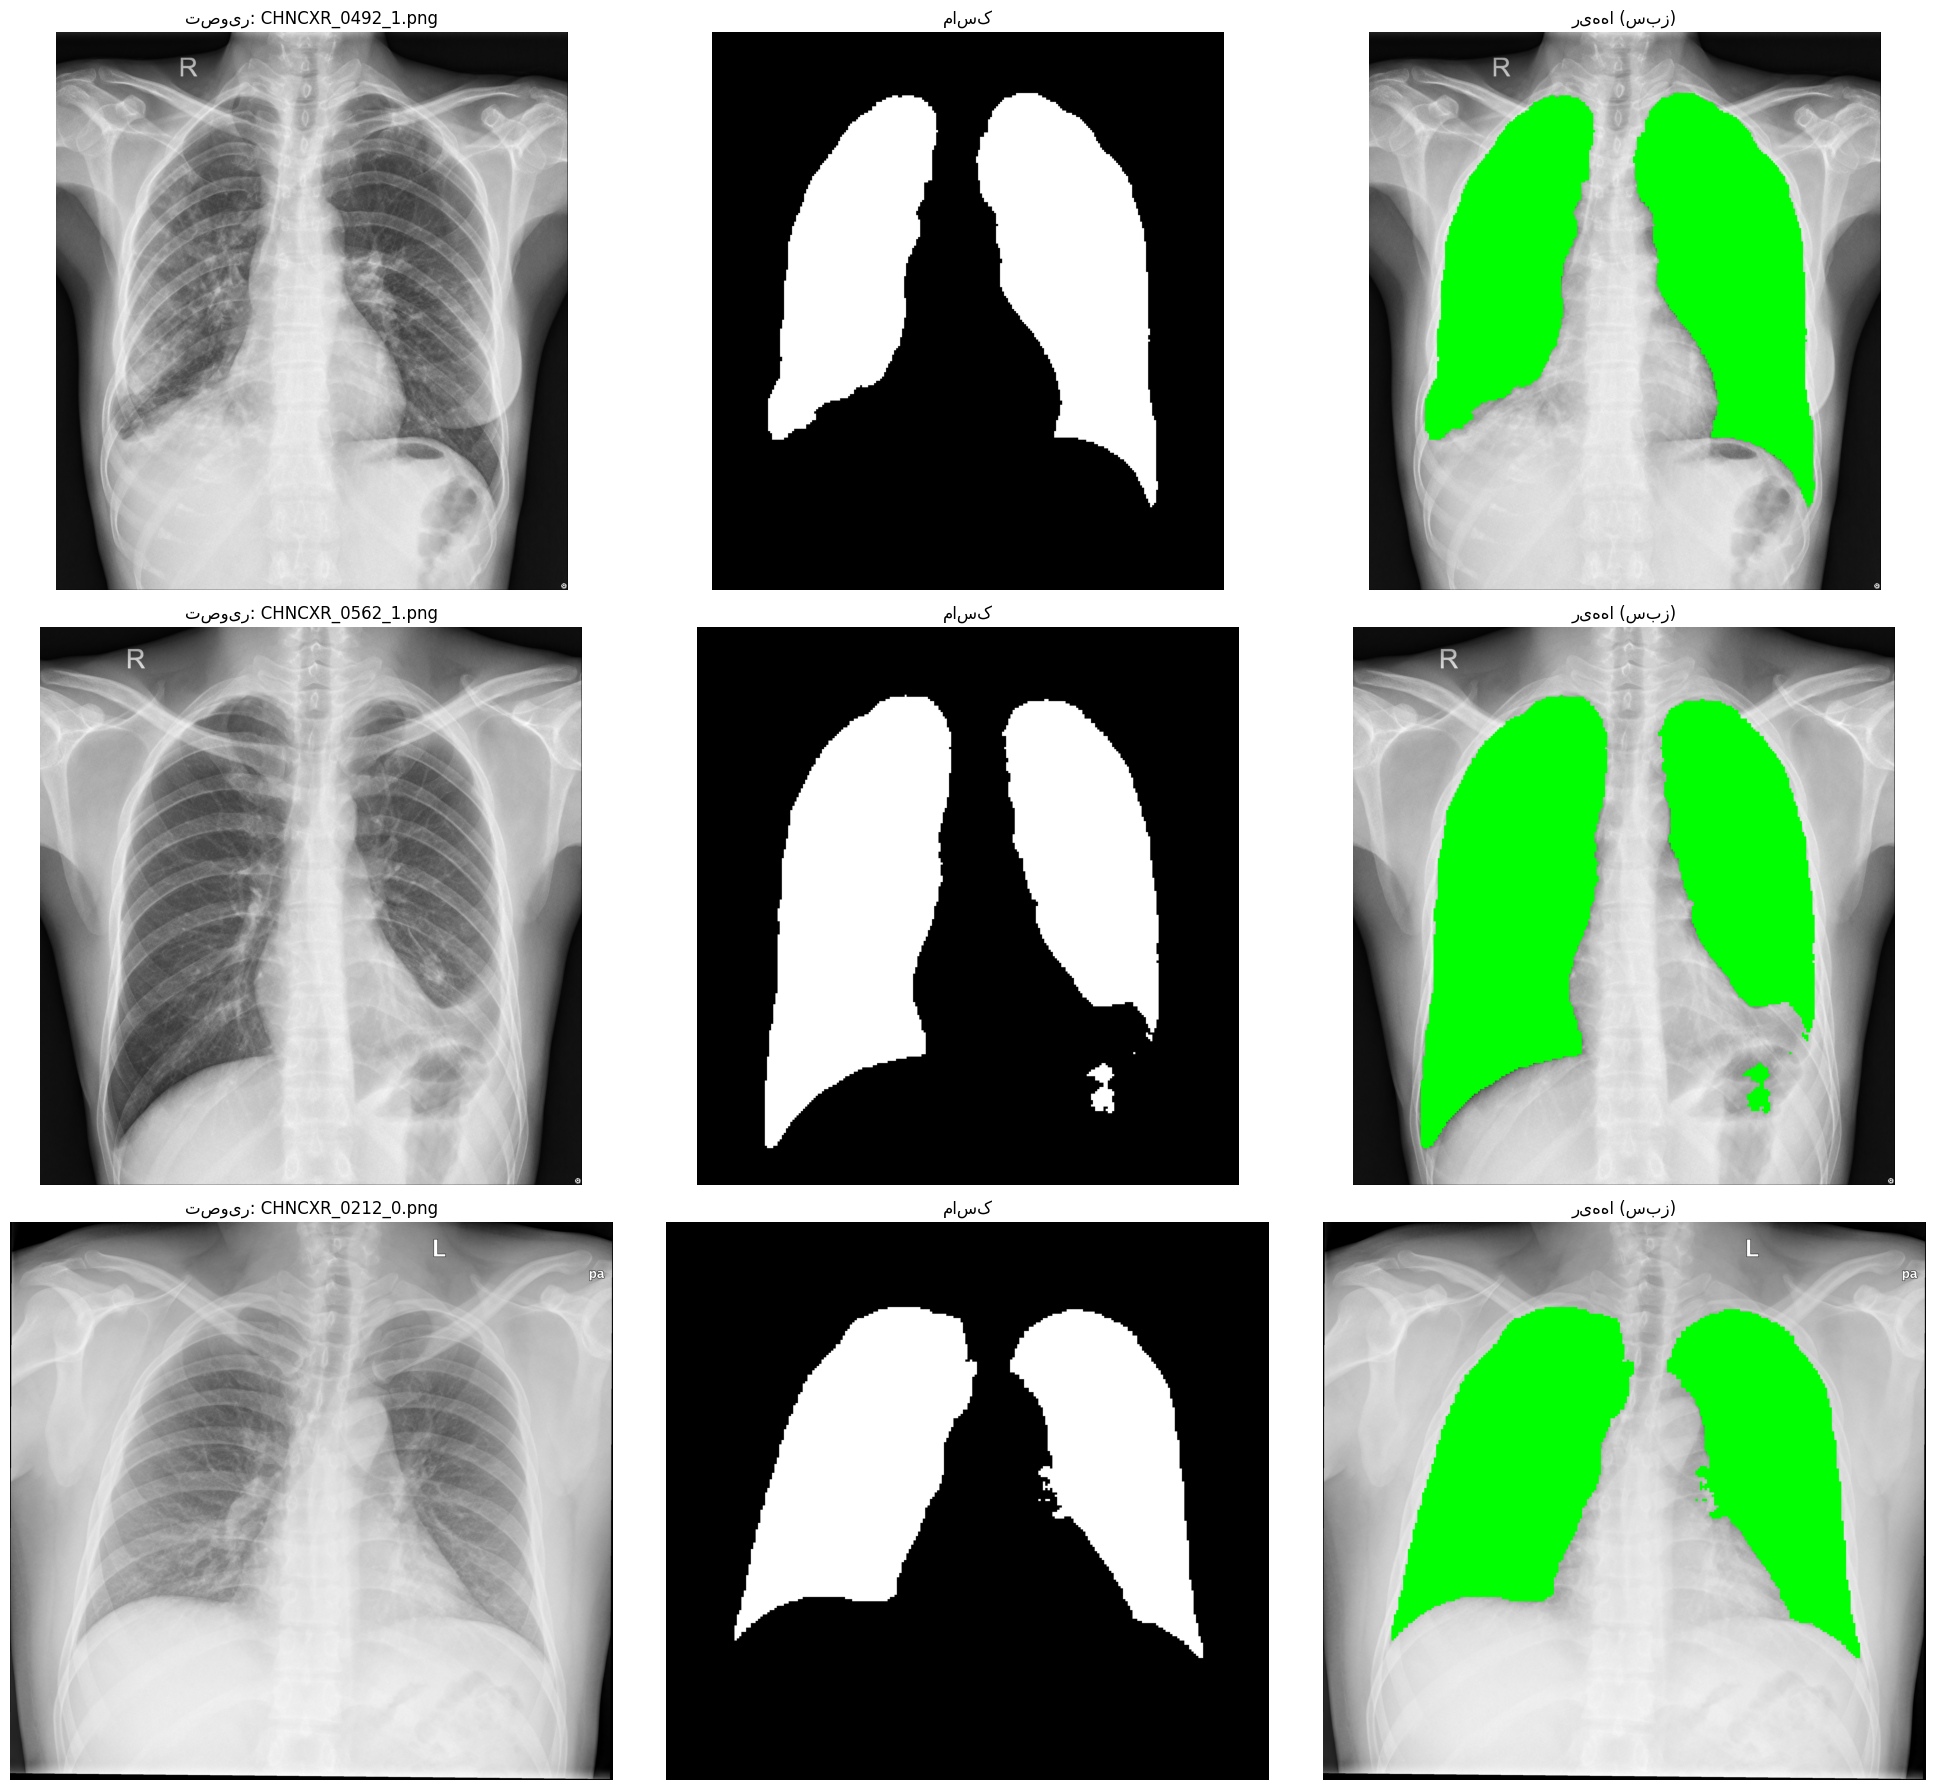

تست کامل شد! ریه‌ها سبز هستند!


In [ ]:
#FINAL CODE

!pip install torch torchvision albumentations matplotlib -q

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import cv2
import os
import random

# --- مسیرها ---
base_path = '/content/lung_dataset/Lung Segmentation'
image_dir = os.path.join(base_path, 'CXR_png_resized')
mask_dir = os.path.join(base_path, 'masks_resized')
test_dir = os.path.join(base_path, 'test')

# --- دیتاست اصلاح‌شده ---
class LungDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        all_images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg'))]

        self.mask_map = {}
        for mask_file in os.listdir(mask_dir):
            if mask_file.lower().endswith(('.png', '.jpg')):
                base = mask_file.replace('_mask.png', '').replace('_mask.jpg', '')
                self.mask_map[base] = mask_file

        self.valid_images = [img for img in all_images if os.path.splitext(img)[0] in self.mask_map]
        self.valid_images = sorted(self.valid_images)

        print(f"تعداد تصاویر با ماسک: {len(self.valid_images)}")

    def __len__(self): return len(self.valid_images)

    def __getitem__(self, idx):
        img_name = self.valid_images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_file = self.mask_map[base_name]
        mask_path = os.path.join(self.mask_dir, mask_file)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']   # ← float32, normalized
            mask = augmented['mask']

        image = torch.from_numpy(image).permute(2, 0, 1).float()  # بدون /255
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

# --- تحولات ---
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
], is_check_shapes=False)

# --- دیتالودر ---
dataset = LungDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# --- چک دیتاست ---
print("\nچک یک بچ...")
for img, mask in dataloader:
    print(f"Image: {img.shape}, min={img.min():.3f}, max={img.max():.3f}")
    print(f"Mask:  {mask.shape}, min={mask.min():.1f}, max={mask.max():.1f}")
    break

# --- مدل U-Net ---
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = double_conv(3, 64); self.pool = nn.MaxPool2d(2)
        self.enc2 = double_conv(64, 128)
        self.enc3 = double_conv(128, 256)
        self.enc4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2); self.dec4 = double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2);  self.dec3 = double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2);  self.dec2 = double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2);   self.dec1 = double_conv(128, 64)
        self.final = nn.Conv2d(64, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.up4(b);  d4 = torch.cat([d4, e4], 1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, e3], 1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], 1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], 1); d1 = self.dec1(d1)
        return torch.sigmoid(self.final(d1))

# --- آموزش ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # lr بالا

print(f"\nشروع آموزش روی {len(dataset)} تصویر...")
losses = []

for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for i, (img, mask) in enumerate(dataloader):
        img, mask = img.to(device), mask.to(device)
        out = model(img)
        loss = criterion(out, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/20] - Loss: {avg_loss:.4f}")

# --- نمودار Loss ---
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# --- ذخیره مدل ---
torch.save(model.state_dict(), '/content/lung_unet_model_final.pth')
print("مدل ذخیره شد: /content/lung_unet_model_final.pth")

# --- تست با سبز ---
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

def predict_with_overlay(image_path):
    img = Image.open(image_path).convert("RGB")
    orig_np = np.array(img)
    transformed = test_transform(image=orig_np)
    tensor = torch.from_numpy(transformed['image']).permute(2, 0, 1).float().unsqueeze(0).to(device)

    with torch.no_grad():
        pred = (model(tensor) > 0.5).float().squeeze(0).squeeze(0).cpu().numpy()

    pred_resized = cv2.resize(pred, (orig_np.shape[1], orig_np.shape[0]), interpolation=cv2.INTER_NEAREST)
    overlay = orig_np.copy()
    overlay[pred_resized > 0.5] = [0, 255, 0]
    return orig_np, pred_resized, overlay

# --- نمایش 3 تصویر ---
test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg'))]
selected = random.sample(test_files, min(3, len(test_files)))

plt.figure(figsize=(20, 6*len(selected)))
for i, name in enumerate(selected):
    path = os.path.join(test_dir, name)
    orig, mask, overlay = predict_with_overlay(path)

    plt.subplot(len(selected), 3, 3*i + 1)
    plt.title(f"تصویر: {name}")
    plt.imshow(orig); plt.axis('off')

    plt.subplot(len(selected), 3, 3*i + 2)
    plt.title("ماسک")
    plt.imshow(mask, cmap='gray'); plt.axis('off')

    plt.subplot(len(selected), 3, 3*i + 3)
    plt.title("ریه‌ها (سبز)")
    plt.imshow(overlay); plt.axis('off')

plt.tight_layout()
plt.show()

print("تست کامل شد! ریه‌ها سبز هستند!")

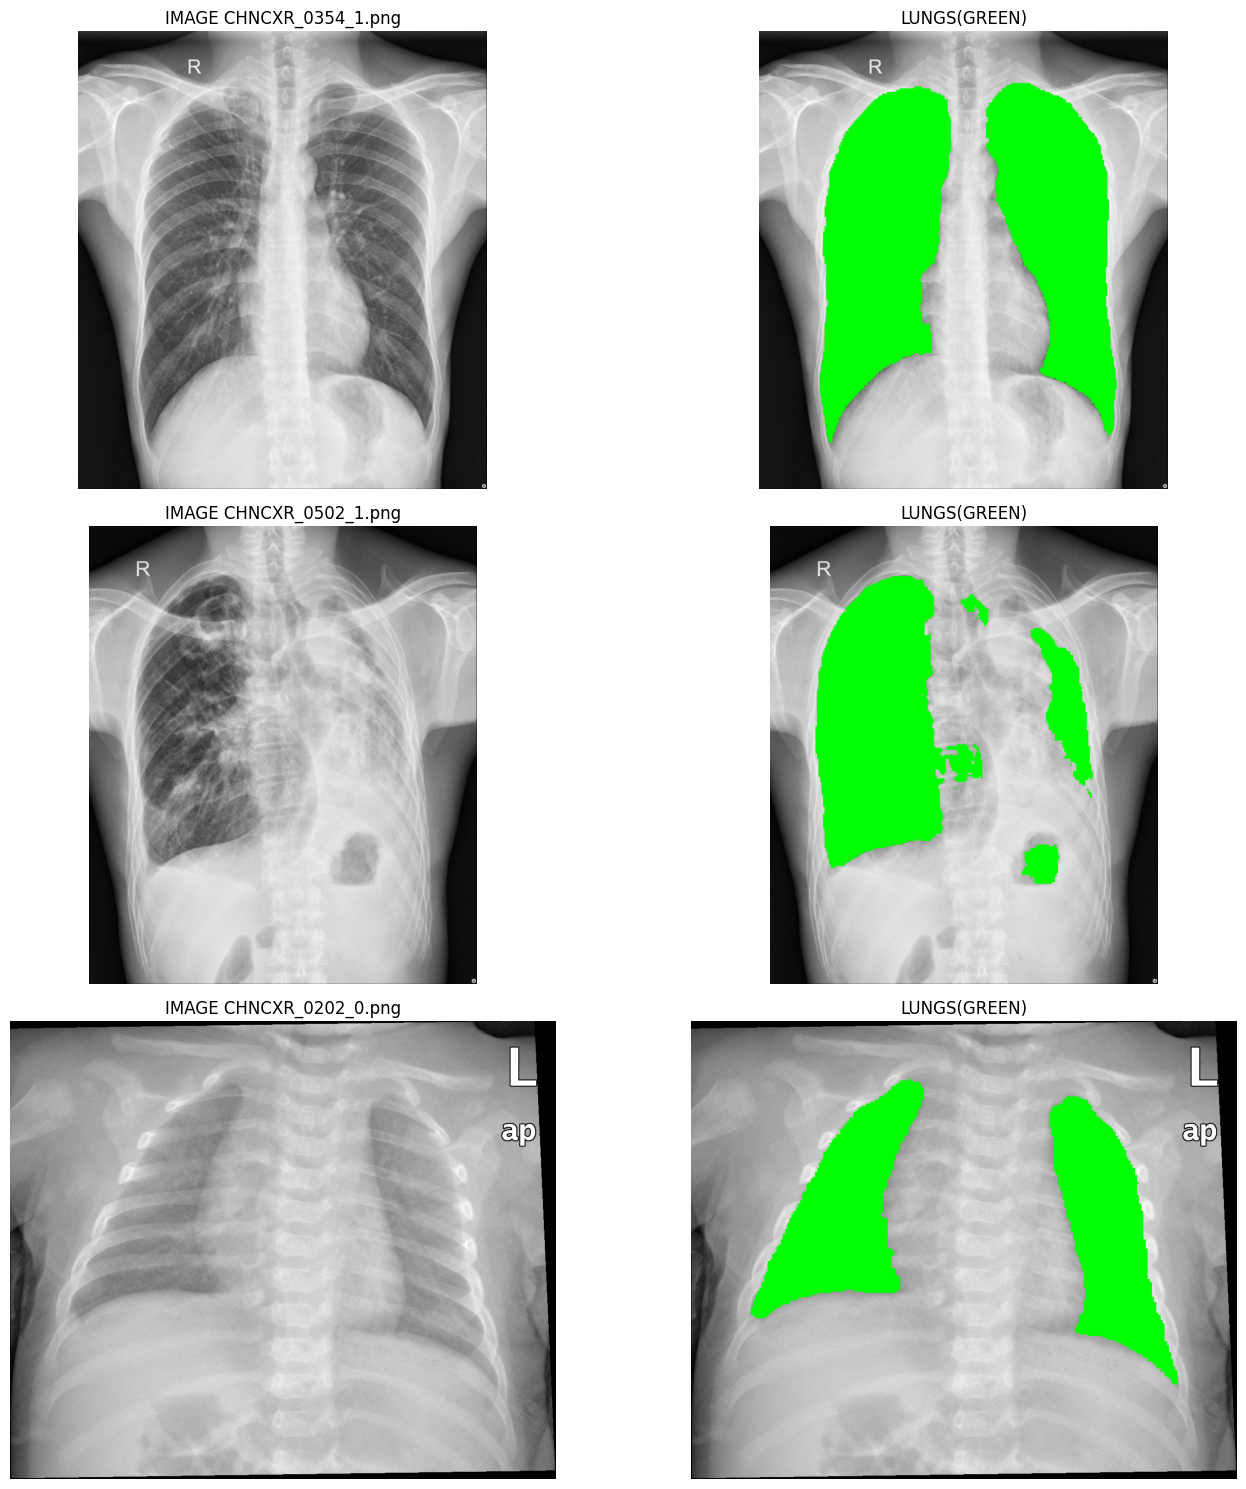

SUCSECC!LUNGS are GREEN


In [ ]:
# -----------------
import torch, cv2, numpy as np, random, os
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('/content/lung_unet_model_final.pth'))
model.eval()

test_transform = A.Compose([A.Resize(256,256),
                           A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))])

test_dir = '/content/lung_dataset/Lung Segmentation/test'
files = random.sample([f for f in os.listdir(test_dir) if f.lower().endswith('.png')], 3)

plt.figure(figsize=(15,5*len(files)))
for i,f in enumerate(files,1):
    img = np.array(Image.open(os.path.join(test_dir,f)).convert('RGB'))
    x   = torch.from_numpy(test_transform(image=img)['image']).permute(2,0,1).float().unsqueeze(0).to(device)
    pred= (model(x)>0.5).float().cpu().numpy()[0,0]
    pred= cv2.resize(pred,(img.shape[1],img.shape[0]),interpolation=cv2.INTER_NEAREST)
    overlay = img.copy(); overlay[pred>0.5]=[0,255,0]

    plt.subplot(len(files),2,2*i-1); plt.title(f'IMAGE {f}'); plt.imshow(img); plt.axis('off')
    plt.subplot(len(files),2,2*i);   plt.title('LUNGS(GREEN)'); plt.imshow(overlay); plt.axis('off')

plt.tight_layout(); plt.show()
print("SUCSECC!LUNGS are GREEN")